## Analysis of Long-Horizon Agents


In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


plt.rcParams.update({
    "font.family": "Inter",
    "font.size": 12,    # base
    "axes.labelsize": 12,   # x/y labels
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def darken(color, factor=0.8):
    """factor <1 darkens, >1 brightens."""
    rgb = np.array(mcolors.to_rgb(color))
    darker = np.clip(rgb * factor, 0, 1)
    return mcolors.to_hex(darker)

In [2]:
BASE_DIR = Path(os.getcwd())

csv_path = BASE_DIR / 'params' / 'all_a_pyirt.csv'
all_runs_path = BASE_DIR / 'data' / 'all_runs.jsonl'
mlebench_results_path = BASE_DIR / 'data' / 'mlebench_normalized_results.jsonl'
gdpval_results_path = BASE_DIR / 'data' / 'gdpval_normalized_results.jsonl'
swebench_results_path = BASE_DIR / 'data' / 'swebench_normalized_results.jsonl'
abilities_path = BASE_DIR / 'params' / 'all_a_pyirt_abilities.csv'

In [3]:
def load_jsonl_records(path: Path):
    records = []
    with path.open('r') as f:
        for line in f:
            records.append(json.loads(line))
    return records

In [4]:
metr_records = load_jsonl_records(all_runs_path)
metr_task_sources = {}
for record in metr_records:
    task_id = record.get('task_id')
    task_source = record.get('task_source')
    if task_id and task_source and task_id not in metr_task_sources:
        metr_task_sources[task_id] = task_source.lower().replace('-', '')

mlebench_task_ids = {record['task_id'] for record in load_jsonl_records(mlebench_results_path)}
gdpval_task_ids = {record['task_id'] for record in load_jsonl_records(gdpval_results_path)}
swebench_task_ids = {record['task_id'] for record in load_jsonl_records(swebench_results_path)}

print(f"# of tasks in METR: {len(metr_task_sources)}")
print(f"# of tasks in MLEBench: {len(mlebench_task_ids)}")
print(f"# of tasks in GDPVal: {len(gdpval_task_ids)}")
print(f"# of tasks in SweBench: {len(swebench_task_ids)}")

# of tasks in METR: 170
# of tasks in MLEBench: 38
# of tasks in GDPVal: 220
# of tasks in SweBench: 500


In [5]:
df = pd.read_csv(csv_path)
task_id_column = df.columns[0]
if task_id_column != 'task_id':
    df = df.rename(columns={task_id_column: 'task_id'})

df['task_id'] = df['task_id'].astype(str)
df['base_task'] = df['task_id'].str.split('::').str[0]
df['metric'] = df['task_id'].str.split('::').str[1]
for numeric_column in ['a', 'b', 'human_minutes']:
    df[numeric_column] = pd.to_numeric(df[numeric_column], errors='coerce')

df['task_source'] = df['task_id'].map(metr_task_sources)
df.loc[df['task_id'].isin(swebench_task_ids), 'task_source'] = 'swebench'
df.loc[df['task_id'].isin(gdpval_task_ids), 'task_source'] = 'gdpval'
df.loc[df['base_task'].isin(mlebench_task_ids), 'task_source'] = 'mlebench'

df['task_source'] = df['task_source'].fillna('Unknown')
print(f"# of tasks by source:\n{df['task_source'].value_counts().to_string()}")


# of tasks by source:
task_source
swebench    500
gdpval      220
mlebench    114
hcast        97
swaa         66
rebench       7


In [6]:
METR_SOURCES = {'hcast', 'rebench', 'swaa'}
use_metr_only = True  # toggle this to False to fit using every available task
if use_metr_only:
    filtered_sources = METR_SOURCES
    source_label = 'METR-only'
else:
    filtered_sources = None
    source_label = 'all sources'

plot_df = df.dropna(subset=['b', 'human_minutes']).copy()
plot_df = plot_df[np.isfinite(plot_df['b']) & np.isfinite(plot_df['human_minutes'])]
plot_df = plot_df[plot_df['human_minutes'] > 0]
if filtered_sources is not None:
    plot_df = plot_df[plot_df['task_source'].isin(filtered_sources)]
if plot_df.empty:
    raise ValueError('No rows with both b and human_minutes values for linear fit')

sources_used = ', '.join(sorted(plot_df['task_source'].dropna().unique())) or 'none'
print(f"Fitting regression on {len(plot_df)} rows ({source_label}; sources: {sources_used})")

x_b = plot_df['b'].to_numpy()
y_log_minutes = np.log(plot_df['human_minutes'].to_numpy())

Fitting regression on 170 rows (METR-only; sources: hcast, rebench, swaa)


In [7]:
reg = stats.linregress(x_b, y_log_minutes)
r_squared = reg.rvalue ** 2

print("-" * 50)
print("Linear Regression: b vs. log(minutes) coefficients")
print("-" * 50)
print(f"> slope: {reg.slope:.6f}")
print(f"> intercept: {reg.intercept:.6f}")
print(f"> r-value: {reg.rvalue:.6f}")
print(f"> R^2: {r_squared:.6f}")
print(f"> p-value: {reg.pvalue:.6g}")
print(f"> std err: {reg.stderr:.6f}")

x_line = np.linspace(x_b.min(), x_b.max(), 500)
y_line = reg.intercept + reg.slope * x_line

def predict_minutes_from_b(b_values):
    return np.exp(reg.intercept + reg.slope * b_values)

--------------------------------------------------
Linear Regression: b vs. log(minutes) coefficients
--------------------------------------------------
> slope: 0.857533
> intercept: 2.699453
> r-value: 0.902875
> R^2: 0.815183
> p-value: 1.73253e-63
> std err: 0.031502


----------------------------------------------------------------------------------------------------
Human Time-to-Complete (log scale) vs Task difficulty (b)
----------------------------------------------------------------------------------------------------


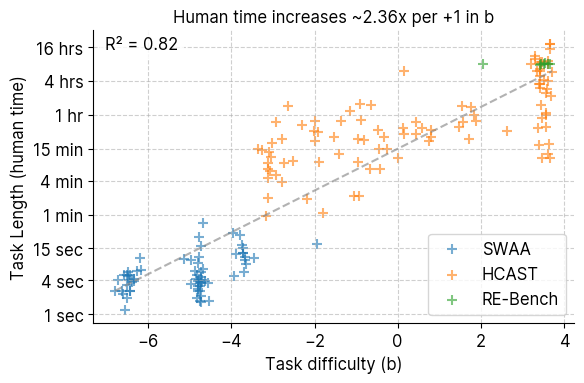

In [8]:
color_map = [
    ('swaa', 'SWAA', '#1f77b4'),
    ('hcast', 'HCAST', '#ff7f0e'),
    ('rebench', 'RE-Bench', '#2ca02c'),
]

print("-" * 100)
print("Human Time-to-Complete (log scale) vs Task difficulty (b)")
print("-" * 100)

fig, ax = plt.subplots(figsize=(6, 4))

for task_source, task_source_label, color in color_map:
    subset = plot_df[plot_df['task_source'] == task_source]
    ax.scatter(subset['b'], subset['human_minutes'], label=task_source_label, color=color, alpha=0.6, marker='+', s=50, linewidth=1.5)

ax.set_yscale('log')
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]
ax.set_yticks(xticks)
ax.set_yticklabels(xtick_labels, ha="right")


ax.plot(x_line, np.exp(y_line), color="#7f7f7f", linestyle='--', alpha=0.6, linewidth=1.5)
ax.set_xlabel("Task difficulty (b)")
ax.set_ylabel("Task Length (human time)")

legend = ax.legend(loc="lower right", frameon=True, fancybox=True)
ax.grid(True, which="major", linestyle="--", alpha=0.6)
ax.minorticks_off()

mult_factor = np.exp(reg.slope)
percent_increase = (mult_factor - 1) * 100

ax.text(
    0.025, 0.98, 
    f"R\u00b2 = {r_squared:.2f}",
    transform=ax.transAxes, 
    ha="left", va="top",
    fontsize=12,
    verticalalignment='top', 
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='white')
)
plt.title(f"Human time increases ~{mult_factor:.2f}x per +1 in b", fontsize=12)

fig.tight_layout()
fig.savefig(BASE_DIR / f'task_difficulty_b_vs_human_time_{source_label.replace(" ", "_")}.png', dpi=300)
plt.show()

In [9]:
mlebench_predictions = df[(df['base_task'].isin(mlebench_task_ids)) & (df['task_source'] == 'mlebench') & (df['b'].notna())]
mlebench_predictions = mlebench_predictions.copy().reset_index(drop=True)
mlebench_predictions['predicted_minutes'] = predict_minutes_from_b(mlebench_predictions['b'])
mlebench_predictions = mlebench_predictions.sort_values(['base_task', 'metric'])
print("-" * 100)
print(f"Predicted human minutes for {len(mlebench_predictions)} MLE Bench task-metrics.")
print("-" * 100)
preview_cols = ['task_id', 'base_task', 'metric', 'b', 'predicted_minutes']
display(mlebench_predictions[preview_cols].head(5))


gdpval_predictions = df[(df['base_task'].isin(gdpval_task_ids)) & (df['task_source'] == 'gdpval') & (df['b'].notna())]
gdpval_predictions = gdpval_predictions.copy().reset_index(drop=True)
gdpval_predictions['predicted_minutes'] = predict_minutes_from_b(gdpval_predictions['b'])
gdpval_predictions = gdpval_predictions.sort_values('task_id')
print("-" * 100)
print(f"Predicted human minutes for {len(gdpval_predictions)} GDPval tasks.")
print("-" * 100)
preview_cols = ['task_id', 'b', 'predicted_minutes']
display(gdpval_predictions[preview_cols].head(5))


swebench_predictions = df[(df['base_task'].isin(swebench_task_ids)) & (df['task_source'] == 'swebench') & (df['b'].notna())]
swebench_predictions = swebench_predictions.copy().reset_index(drop=True)
swebench_predictions['predicted_minutes'] = predict_minutes_from_b(swebench_predictions['b'])
swebench_predictions = swebench_predictions.sort_values('task_id')
print("-" * 100)
print(f"Predicted human minutes for {len(swebench_predictions)} SWE-bench tasks.")
print("-" * 100)
preview_cols = ['task_id', 'human_minutes', 'b', 'predicted_minutes']
display(swebench_predictions[preview_cols].head(5))


----------------------------------------------------------------------------------------------------
Predicted human minutes for 114 MLE Bench task-metrics.
----------------------------------------------------------------------------------------------------


,task_id,base_task,metric,b,predicted_minutes
60,AI4Code::above_median,AI4Code,above_median,4.317305,602.860851
61,AI4Code::any_medal,AI4Code,any_medal,4.210889,550.282261
62,AI4Code::valid_submission,AI4Code,valid_submission,-3.287810,0.886962
0,aerial-cactus-identification::above_median,aerial-cactus-identification,above_median,4.415765,655.972795
1,aerial-cactus-identification::any_medal,aerial-cactus-identification,any_medal,4.860632,960.648098


----------------------------------------------------------------------------------------------------
Predicted human minutes for 220 GDPval tasks.
----------------------------------------------------------------------------------------------------


,task_id,b,predicted_minutes
0,0112fc9b-c3b2-4084-8993-5a4abb1f54f1,-3.212518,0.946118
1,01d7e53e-0513-4109-a242-8ccaf442cd21,-0.300184,11.496417
2,02314fc6-a24e-42f4-a8cd-362cae0f0ec1,-2.034356,2.598475
3,02aa1805-c658-4069-8a6a-02dec146063a,0.591576,24.698674
4,0353ee0c-18b5-4ad3-88e8-e001d223e1d7,1.451648,51.639651


----------------------------------------------------------------------------------------------------
Predicted human minutes for 500 SWE-bench tasks.
----------------------------------------------------------------------------------------------------


,task_id,human_minutes,b,predicted_minutes
0,astropy__astropy-12907,30.0,-0.751985,7.803723
1,astropy__astropy-13033,30.0,5.261611,1354.869296
2,astropy__astropy-13236,30.0,4.705755,841.171697
3,astropy__astropy-13398,120.0,5.174008,1256.817610
4,astropy__astropy-13453,30.0,0.050804,15.533822


/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_34512/3823193248.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = swebench_predictions.groupby(['time_bucket', 'correct_bucket']).size().unstack(fill_value=0)


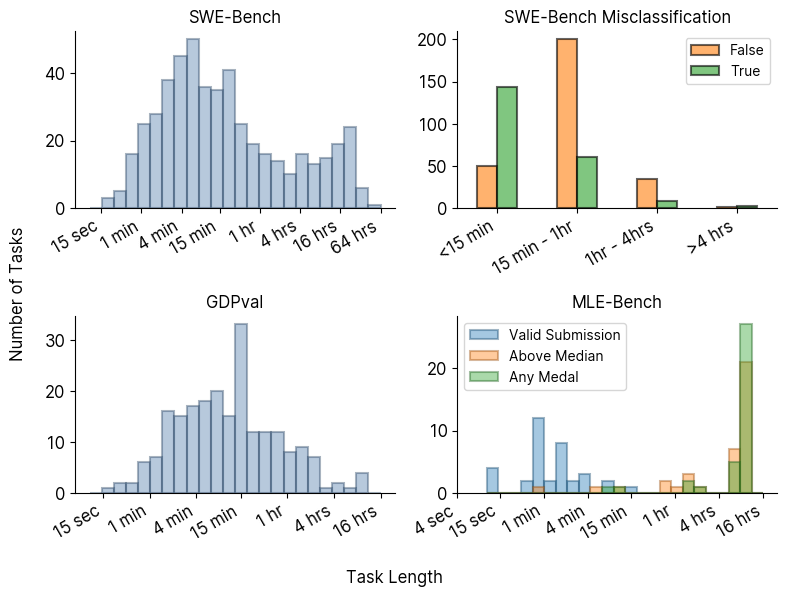

In [10]:
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

# -----------------------------------------------
# subplot 1: SWE human_minutes histogram (1, 1)
# -----------------------------------------------
ax = axes[0]

minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:])
ax.set_xticklabels(xtick_labels[2:], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("SWE-Bench", fontsize=12)


# -----------------------------------------------
# subplot 2: SWE predicted_minutes misclassification (1, 2)
# -----------------------------------------------
ax = axes[1]
bins = [0, 15, 60, 240, np.inf]
labels = ['<15 min', '15 min - 1hr', '1hr - 4hrs', '>4 hrs']

# keep interval information
intervals = pd.cut(
    swebench_predictions['human_minutes'],
    bins=bins,
    include_lowest=True
)

# readable bucket label
swebench_predictions['time_bucket'] = intervals.map(lambda iv: labels[bins.index(iv.right) - 1])

# correctness check based on interval bounds
is_correct = []
for i, row in swebench_predictions.iterrows():
    is_correct.append(row['predicted_minutes'] >= intervals.iloc[i].left and row['predicted_minutes'] <= intervals.iloc[i].right)
swebench_predictions['correct_bucket'] = is_correct

# plot the bar chart with correct and incorrect counts across buckets
bucket_counts = swebench_predictions.groupby(['time_bucket', 'correct_bucket']).size().unstack(fill_value=0)
bucket_counts = bucket_counts.reindex(labels)  # ensure consistent order

bucket_counts.plot(
    kind='bar',
    stacked=False,
    color=['#ff7f0e', '#2ca02c'],
    edgecolor='black',
    alpha=0.6,
    linewidth=1.5,
    ax=ax
)

ax.set_xlabel(None)
# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.minorticks_off()

ax.set_title("SWE-Bench Misclassification", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)

# -----------------------------------------------
# subplot 3: MLE bench human_minutes histogram (2, 1)
# -----------------------------------------------
ax = axes[3]

mle_metric_specs = [
    ('valid_submission', '#1f77b4'),
    ('above_median', '#ff7f0e'),
    ('any_medal', '#2ca02c'),
]

for spec_name, color in mle_metric_specs:
    mlebench_predictions_subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    minutes = mlebench_predictions_subset["predicted_minutes"]
    minutes = minutes[np.isfinite(minutes) & (minutes > 0)].to_numpy()

    bins = np.geomspace(10/60, 16*60, 25)
    ax.hist(
        minutes, bins=bins, color=color, alpha=0.4, 
        edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title()
    )

ax.set_xscale('log')
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xtick_labels[1:-1], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("MLE-Bench", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)


# -----------------------------------------------
# subplot 4: GDPval human_minutes histogram (2, 2)
# -----------------------------------------------
ax = axes[2]

minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:-1])
ax.set_xticklabels(xtick_labels[2:-1], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("GDPval", fontsize=12)

fig.supxlabel("Task Length", fontsize=12)
fig.supylabel("Number of Tasks", fontsize=12)

fig.tight_layout(pad=1)
plt.show()

/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_34512/391184379.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha="right", rotation=30)


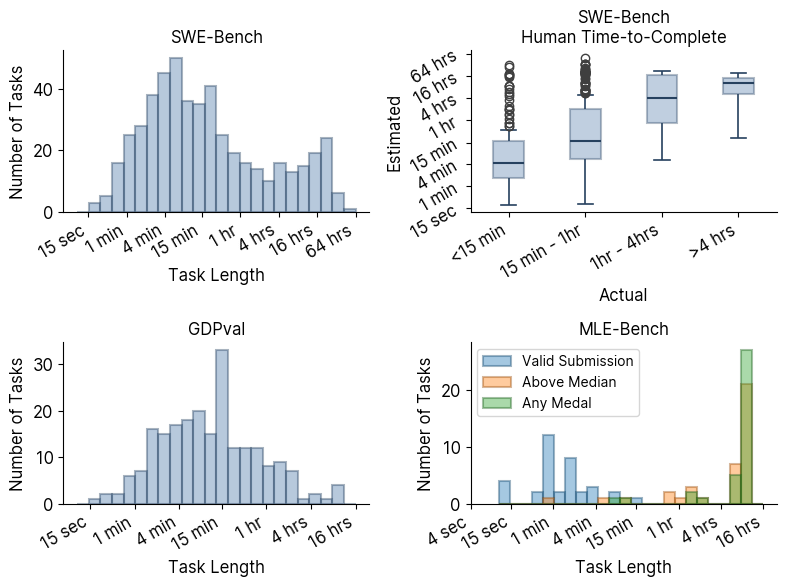

In [11]:
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

# -----------------------------------------------
# subplot 1: SWE human_minutes histogram (1, 1)
# -----------------------------------------------
ax = axes[0]

minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:])
ax.set_xticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("SWE-Bench", fontsize=12)


# -----------------------------------------------
# subplot 2: SWE predicted_minutes misclassification (1, 2)
# -----------------------------------------------
ax = axes[1]
bins = [0, 15, 60, 240, np.inf]
labels = ['<15 min', '15 min - 1hr', '1hr - 4hrs', '>4 hrs']

# keep interval information
intervals = pd.cut(
    swebench_predictions['human_minutes'],
    bins=bins,
    include_lowest=True
)

# readable bucket label
swebench_predictions['time_bucket'] = intervals.map(lambda iv: labels[bins.index(iv.right) - 1])

# boxplot between time buckets [x] and predicted minutes [y]
sns.boxplot(
    data=swebench_predictions,
    x='time_bucket',
    y='predicted_minutes',
    ax=ax,
    width=0.4,
    boxprops=dict(
        facecolor="#4c78a8",
        alpha=0.35,
        edgecolor="#26415f",
        linewidth=1.5,
    ),
    whiskerprops=dict(color="#26415f", linewidth=1.2),
    capprops=dict(color="#26415f", linewidth=1.2),
    medianprops=dict(color="#26415f", linewidth=1.5),
)

ax.set_yscale('log')
ax.set_yticks(xticks[2:])
ax.set_yticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Actual")
ax.set_ylabel("Estimated")
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.minorticks_off()

ax.set_title("SWE-Bench\nHuman Time-to-Complete", fontsize=12)


# -----------------------------------------------
# subplot 3: MLE bench human_minutes histogram (2, 1)
# -----------------------------------------------
ax = axes[3]

mle_metric_specs = [
    ('valid_submission', '#1f77b4'),
    ('above_median', '#ff7f0e'),
    ('any_medal', '#2ca02c'),
]

for spec_name, color in mle_metric_specs:
    mlebench_predictions_subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    minutes = mlebench_predictions_subset["predicted_minutes"]
    minutes = minutes[np.isfinite(minutes) & (minutes > 0)].to_numpy()

    bins = np.geomspace(10/60, 16*60, 25)
    ax.hist(
        minutes, bins=bins, color=color, alpha=0.4, 
        edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title()
    )

ax.set_xscale('log')
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xtick_labels[1:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("MLE-Bench", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)


# -----------------------------------------------
# subplot 4: GDPval human_minutes histogram (2, 2)
# -----------------------------------------------
ax = axes[2]

minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:-1])
ax.set_xticklabels(xtick_labels[2:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("GDPval", fontsize=12)

fig.tight_layout(pad=1)
plt.show()

In [12]:
abilities_df = pd.read_csv(abilities_path)
model_df = abilities_df.copy()
model_df['release_time'] = pd.to_datetime(model_df['release_time'], errors='coerce')
model_df = model_df.dropna(subset=['release_time'])
model_df = model_df.rename(columns={'subject_id': 'model_name'})

bucket_span_months = 5
release_month_numbers = (model_df['release_time'].dt.year * 12 + (model_df['release_time'].dt.month - 1)).astype(int)
anchor_month_number = release_month_numbers.min()

# Assume buckets start from the anchor month number
bucket_indices = ((release_month_numbers - anchor_month_number) // bucket_span_months).astype(int)
bucket_month_numbers = anchor_month_number + bucket_indices * bucket_span_months

bucket_years = bucket_month_numbers // 12
bucket_month_in_year = (bucket_month_numbers % 12) + 1
model_df['bucket_start'] = pd.to_datetime({'year': bucket_years, 'month': bucket_month_in_year, 'day': 1})

bucketed_models_df = model_df.sort_values('ability', ascending=False).groupby('bucket_start', as_index=False).first().sort_values('bucket_start')
display(bucketed_models_df.head(5))

,bucket_start,model_name,ability,release_time
0,2019-02-01,gpt2,-5.521043,2019-02-14
1,2022-01-01,gpt-3.5-turbo-instruct,-3.356530,2022-03-15
2,2022-11-01,gpt-4-0314,-1.613085,2023-03-14
3,2023-09-01,gpt-4-1106,-1.982036,2023-11-06
4,2024-02-01,claude-3-5-sonnet-20240620,-0.488094,2024-06-20


In [ ]:
def success_prob(ability, a, b):
    """Calcualate success probability using 2PL IRT model."""
    exp_term = np.exp(-a * (ability - b))
    prob = 1 / (1 + exp_term)
    return prob


model_to_success_prob = []
for i, row in bucketed_models_df.iterrows():
    ability = row['ability']
    model_name = row['model_name']
    release_time = row['release_time']
    bucket_start = row['bucket_start']
    
    task_sources = [
        ("swebench", swebench_predictions),
        ("mlebench", mlebench_predictions),
        ("gdpval", gdpval_predictions),
    ]
    
    # calculate success probability for each task in each source
    for task_source_name, task_source_df in task_sources:
        for j, task_row in task_source_df.iterrows():
            task_id = task_row['task_id']
            a = task_row['a']
            b = task_row['b']
            predicted_time = task_row['predicted_minutes']
            prob = success_prob(ability, a, b)
            model_to_success_prob.append({
                "model_name": model_name, 
                "release_time": release_time, 
                "bucket_start": bucket_start, 
                "task_id": task_id, 
                "task_source": task_source_name,
                "success_prob": prob,
                "predicted_minutes": predicted_time,
                "difficulty_b": b,
            })

model_to_success_prob_df = pd.DataFrame(model_to_success_prob)
model_to_success_prob_df.head(5)

,model_name,release_time,bucket_start,task_id,task_source,success_prob,predicted_minutes,difficulty_b
0,gpt2,2019-02-14,2019-02-01,astropy__astropy-12907,swebench,5.477374e-05,7.803723,-0.751985
1,gpt2,2019-02-14,2019-02-01,astropy__astropy-13033,swebench,1.800280e-05,1354.869296,5.261611
2,gpt2,2019-02-14,2019-02-01,astropy__astropy-13236,swebench,3.162856e-03,841.171697,4.705755
3,gpt2,2019-02-14,2019-02-01,astropy__astropy-13398,swebench,4.847221e-09,1256.817610,5.174008
4,gpt2,2019-02-14,2019-02-01,astropy__astropy-13453,swebench,7.260400e-05,15.533822,0.050804


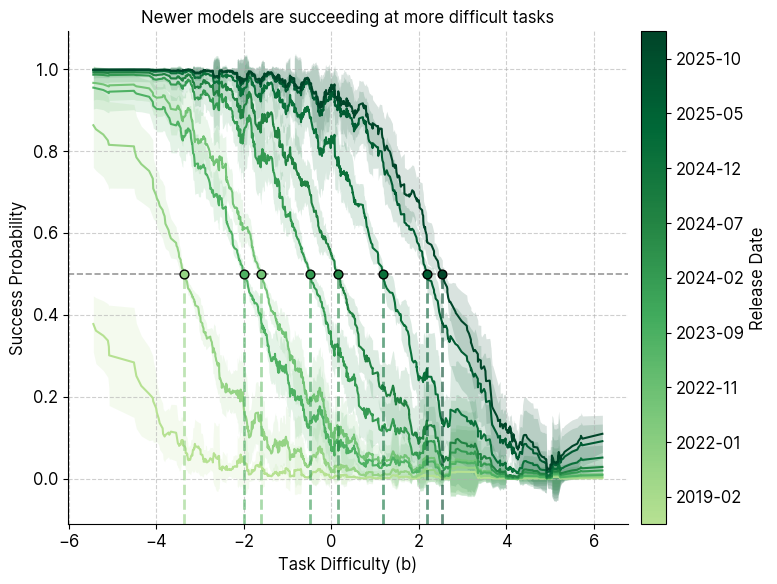

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

bucket_starts = model_to_success_prob_df['bucket_start'].sort_values().unique()
n_buckets = len(bucket_starts)

# --- continuous colormap, slightly truncated at the bottom ---
base_cmap = plt.get_cmap('YlGn')
# base_cmap = plt.get_cmap('BuGn')   # 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r'

def truncate_cmap(cmap, minval=0.25, maxval=1.0, n=256):
    """Cut off the very lightest colors so the bottom is more visible."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap = truncate_cmap(base_cmap, 0.35, 1.0)  # bottom now darker but still ordered

window = 15  # number of points in the smoothing window
threshold = 0.5

# draw horizontal line at success prob = 0.5
ax.axhline(threshold, color="#7f7f7f", linestyle="--", linewidth=1.2, alpha=0.8)

b_at_50 = {}  # store mapping: bucket_start -> difficulty b at ~0.5

for i, bucket_start in enumerate(bucket_starts):
    subset = model_to_success_prob_df[
        model_to_success_prob_df['bucket_start'] == bucket_start
    ].sort_values('difficulty_b')

    # rolling mean/std to smooth
    mean = subset['success_prob'].rolling(window=window, center=True, min_periods=3).mean()
    std = subset['success_prob'].rolling(window=window, center=True, min_periods=3).std().fillna(0)

    x = subset['difficulty_b'].to_numpy()
    y = mean.to_numpy()
    y_lower = y - std.to_numpy()
    y_upper = y + std.to_numpy()

    # sample along the *continuous* colormap
    color = cmap(i / (n_buckets - 1)) if n_buckets > 1 else cmap(0.5)

    # smoothed line
    ax.plot(
        x, y,
        color=color,
        label=bucket_start.strftime('%Y-%m'),
        linewidth=1.5,
    )

    # shaded error band
    ax.fill_between(
        x, y_lower, y_upper,
        color=color,
        alpha=0.15,
        linewidth=0,
    )
    
    # ---- find difficulty b where success_prob ~ 0.5 ----
    mask = ~np.isnan(y)
    x_valid = x[mask]
    y_valid = y[mask]

    if len(x_valid) == 0:
        continue
    
    # if max success prob is below threshold, skip this bucket
    if y_valid.max() < threshold:
        continue

    # index where |y - 0.5| is minimal
    idx = np.argmin(np.abs(y_valid - threshold))
    b_star = x_valid[idx]
    b_at_50[bucket_start] = b_star

    # mark this point on the plot
    ax.scatter(
        b_star, threshold,
        color=color,
        edgecolor="black",
        s=40,
        zorder=5,
    )
    
    ax.axvline(
        b_star, 
        ymin=0, ymax=threshold,
        color=color,
        linestyle="--", 
        linewidth=2,
        alpha=0.6,
    )

ax.set_ylabel("Success Probability")
ax.set_xlabel("Task Difficulty (b)")
ax.set_title("Newer models are succeeding at more difficult tasks", fontsize=12)

# ---- continuous colorbar ----
norm = plt.Normalize(vmin=-0.5, vmax=n_buckets - 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Release Date")

ticks = np.arange(n_buckets)
cbar.set_ticks(ticks)
cbar.set_ticklabels([b.strftime('%Y-%m') for b in bucket_starts])

ax.grid(True, which="major", linestyle="--", alpha=0.6)
ax.minorticks_off()

plt.tight_layout()
plt.show()


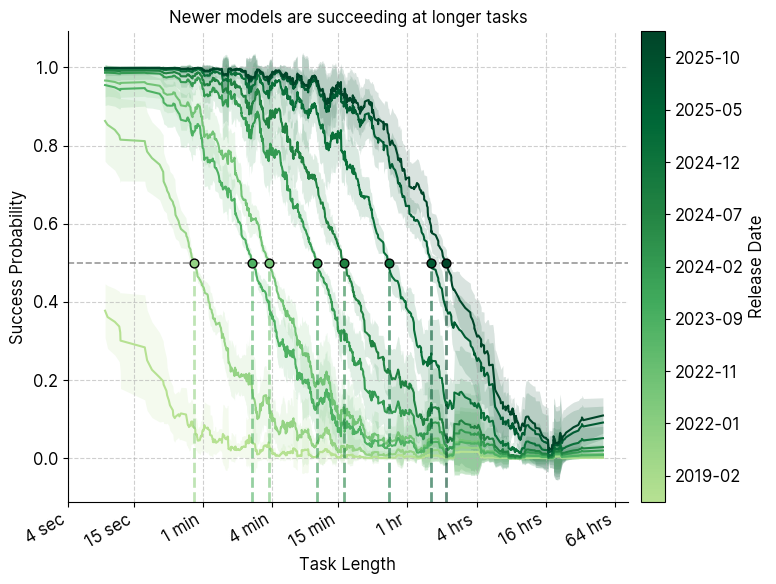

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

bucket_starts = model_to_success_prob_df['bucket_start'].sort_values().unique()
n_buckets = len(bucket_starts)

# --- continuous colormap, slightly truncated at the bottom ---
base_cmap = plt.get_cmap('YlGn')
# base_cmap = plt.get_cmap('BuGn')   # 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r'

def truncate_cmap(cmap, minval=0.25, maxval=1.0, n=256):
    """Cut off the very lightest colors so the bottom is more visible."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap = truncate_cmap(base_cmap, 0.35, 1.0)  # bottom now darker but still ordered

window = 15  # number of points in the smoothing window
threshold = 0.5

# draw horizontal line at success prob = 0.5
ax.axhline(threshold, color="#7f7f7f", linestyle="--", linewidth=1.2, alpha=0.8)

b_at_50 = {}  # store mapping: bucket_start -> difficulty b at ~0.5

for i, bucket_start in enumerate(bucket_starts):
    subset = model_to_success_prob_df[
        model_to_success_prob_df['bucket_start'] == bucket_start
    ].sort_values('predicted_minutes')

    # rolling mean/std to smooth
    mean = subset['success_prob'].rolling(window=window, center=True, min_periods=3).mean()
    std = subset['success_prob'].rolling(window=window, center=True, min_periods=3).std().fillna(0)

    x = subset['predicted_minutes'].to_numpy()
    y = mean.to_numpy()
    y_lower = y - std.to_numpy()
    y_upper = y + std.to_numpy()

    # sample along the *continuous* colormap
    color = cmap(i / (n_buckets - 1)) if n_buckets > 1 else cmap(0.5)

    # smoothed line
    ax.plot(
        x, y,
        color=color,
        label=bucket_start.strftime('%Y-%m'),
        linewidth=1.5,
    )

    # shaded error band
    ax.fill_between(
        x, y_lower, y_upper,
        color=color,
        alpha=0.15,
        linewidth=0,
    )
    
    # ---- find difficulty b where success_prob ~ 0.5 ----
    mask = ~np.isnan(y)
    x_valid = x[mask]
    y_valid = y[mask]

    if len(x_valid) == 0:
        continue
    
    # if max success prob is below threshold, skip this bucket
    if y_valid.max() < threshold:
        continue

    # index where |y - 0.5| is minimal
    idx = np.argmin(np.abs(y_valid - threshold))
    b_star = x_valid[idx]
    b_at_50[bucket_start] = b_star

    # mark this point on the plot
    ax.scatter(
        b_star, threshold,
        color=color,
        edgecolor="black",
        s=40,
        zorder=5,
    )
    
    ax.axvline(
        b_star, 
        ymin=0, ymax=threshold,
        color=color,
        linestyle="--", 
        linewidth=2,
        alpha=0.6,
    )

ax.set_xscale('log')
xticks = [
    4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, ha="right", rotation=30)

ax.set_ylabel("Success Probability")
ax.set_xlabel("Task Length")
ax.set_title("Newer models are succeeding at longer tasks", fontsize=12)

# ---- continuous colorbar ----
norm = plt.Normalize(vmin=-0.5, vmax=n_buckets - 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Release Date")

ticks = np.arange(n_buckets)
cbar.set_ticks(ticks)
cbar.set_ticklabels([b.strftime('%Y-%m') for b in bucket_starts])

ax.grid(True, which="major", linestyle="--", alpha=0.6)
ax.minorticks_off()

plt.tight_layout()
plt.show()


In [51]:
all_models_to_success_prob = []
for i, row in model_df.iterrows():
    ability = row['ability']
    model_name = row['model_name']
    release_time = row['release_time']
    bucket_start = row['bucket_start']
    
    task_sources = [
        ("swebench", swebench_predictions),
        ("mlebench", mlebench_predictions),
        ("gdpval", gdpval_predictions),
    ]
    
    # calculate success probability for each task in each source
    for task_source_name, task_source_df in task_sources:
        for j, task_row in task_source_df.iterrows():
            task_id = task_row['task_id']
            a = task_row['a']
            b = task_row['b']
            predicted_time = task_row['predicted_minutes']
            prob = success_prob(ability, a, b)
            all_models_to_success_prob.append({
                "model_name": model_name, 
                "release_time": release_time, 
                "bucket_start": bucket_start, 
                "task_id": task_id, 
                "task_source": task_source_name,
                "success_prob": prob,
                "predicted_minutes": predicted_time,
                "difficulty_b": b,
            })

all_models_to_success_prob_df = pd.DataFrame(all_models_to_success_prob)
all_models_to_success_prob_df.head(5)

,model_name,release_time,bucket_start,task_id,task_source,success_prob,predicted_minutes,difficulty_b
0,gpt2,2019-02-14,2019-02-01,astropy__astropy-12907,swebench,5.477374e-05,7.803723,-0.751985
1,gpt2,2019-02-14,2019-02-01,astropy__astropy-13033,swebench,1.800280e-05,1354.869296,5.261611
2,gpt2,2019-02-14,2019-02-01,astropy__astropy-13236,swebench,3.162856e-03,841.171697,4.705755
3,gpt2,2019-02-14,2019-02-01,astropy__astropy-13398,swebench,4.847221e-09,1256.817610,5.174008
4,gpt2,2019-02-14,2019-02-01,astropy__astropy-13453,swebench,7.260400e-05,15.533822,0.050804


Model: gpt-3.5-turbo-instruct | b@50%: -3.37 ± 0.03 | time@50%: 0.83 ± 0.02 minutes
Model: gpt-3 | b@50%: -3.99 ± 0.07 | time@50%: 0.49 ± 0.03 minutes
Model: gpt-4-0314 | b@50%: -1.62 ± 0.01 | time@50%: 3.72 ± 0.05 minutes
Model: gpt-4-1106 | b@50%: -2.00 ± 0.03 | time@50%: 2.68 ± 0.07 minutes
Model: gpt-4-0125 | b@50%: -2.01 ± 0.01 | time@50%: 2.65 ± 0.03 minutes
Model: claude-3-opus | b@50%: -2.40 ± 0.01 | time@50%: 1.90 ± 0.01 minutes
Model: gpt-4-turbo | b@50%: -1.63 ± 0.01 | time@50%: 3.69 ± 0.03 minutes
Model: gpt-4o-2024-05-13 | b@50%: -1.04 ± 0.01 | time@50%: 6.12 ± 0.06 minutes
Model: claude-3-5-sonnet-20240620 | b@50%: -0.48 ± 0.03 | time@50%: 9.83 ± 0.24 minutes
Model: o1-preview | b@50%: 0.14 ± 0.02 | time@50%: 16.82 ± 0.27 minutes
Model: qwen2.5-coder-32b-inst | b@50%: -3.92 ± 0.08 | time@50%: 0.51 ± 0.03 minutes
Model: claude-3-5-sonnet-20241022 | b@50%: 0.08 ± 0.00 | time@50%: 15.89 ± 0.05 minutes
Model: o1 | b@50%: 0.85 ± 0.02 | time@50%: 30.77 ± 0.58 minutes
Model: o3-

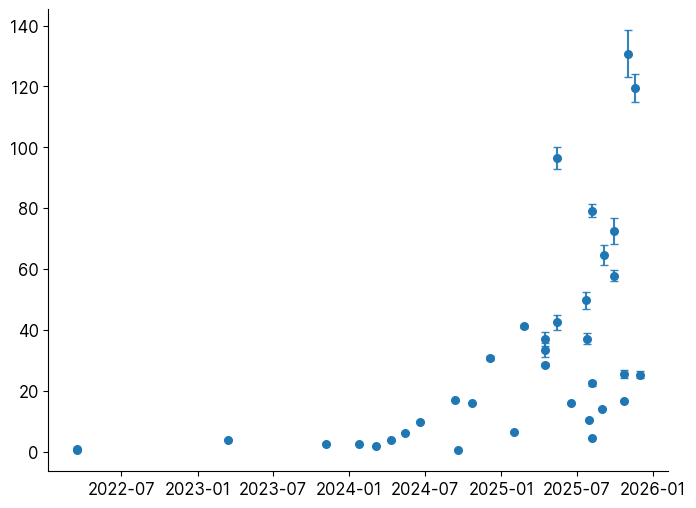

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

model_names = all_models_to_success_prob_df["model_name"].unique().tolist()

window = 15  # number of points in the smoothing window
threshold = 0.5

for model_name in model_names:
    subset = all_models_to_success_prob_df[all_models_to_success_prob_df['model_name'] == model_name].sort_values('predicted_minutes')

    # rolling mean/std to smooth
    mean = subset['success_prob'].rolling(window=window, center=True, min_periods=3).mean()
    std = subset['success_prob'].rolling(window=window, center=True, min_periods=3).std().fillna(0)

    x = subset['difficulty_b'].to_numpy()
    y = mean.to_numpy()
    y_lower = y - std.to_numpy()
    y_upper = y + std.to_numpy()

    # ---- find difficulty b where success_prob ~ 0.5 ----
    mask = ~np.isnan(y)
    x_valid = x[mask]
    y_valid = y[mask]
    
    if len(x_valid) == 0:
        continue
    
    # if max success prob is below threshold, skip this bucket
    if y_valid.max() < threshold:
        continue

    # index where |y - 0.5| is minimal
    idx = np.argmin(np.abs(y_valid - threshold))
    b_star = x_valid[idx]
    
    # calculate std dev of b where success prob is within 1 std dev of threshold
    within_std_mask = (y_valid >= (threshold - std.to_numpy()[mask][idx])) & (y_valid <= (threshold + std.to_numpy()[mask][idx]))
    b_std = x_valid[within_std_mask].std()
    
    # map difficulty to time estimate
    time_estimate = predict_minutes_from_b(b_star)
    time_std = predict_minutes_from_b(b_star + b_std) - time_estimate

    release_time = subset['release_time'].iloc[0]

    # smoothed line
    ax.scatter(
        release_time, time_estimate,
        color="#1f77b4",
        s=30,
        label=model_name,
    )

    # shaded error band
    ax.errorbar(
        release_time,
        time_estimate,
        yerr=time_std,
        fmt='o',
        color="#1f77b4",
        markersize=4,
        capsize=3,
        alpha=0.9,
    )

plt.show()

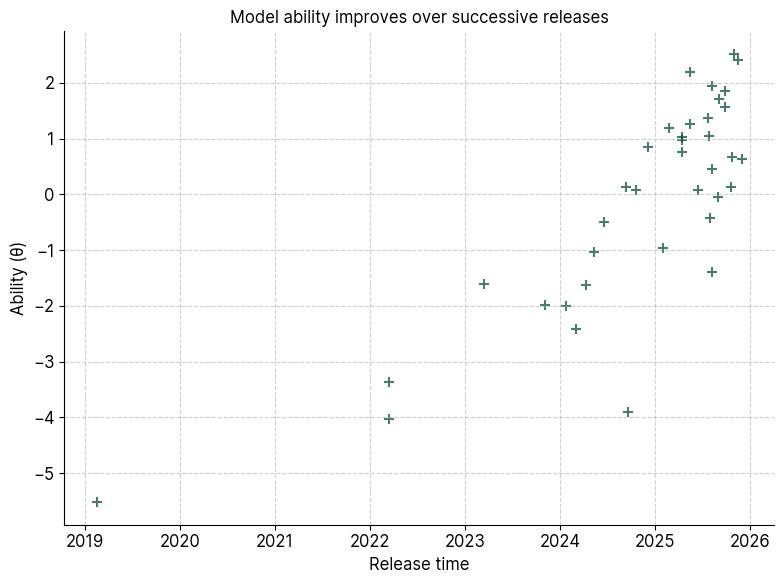

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# color_map = [
#     # (substring_to_match_in_model_name, legend_label, color)
#     ('gpt',   'GPT family',   '#1f77b4'),
#     ('claude','Claude family','#ff7f0e'),
#     ('qwen',  'Qwen family',  '#2ca02c'),
#     # add / change as needed
# ]

# ensure points are in time order (optional, useful if you later add lines)
model_df = model_df.sort_values('release_time')

ax.scatter(
    model_df['release_time'],
    model_df['ability'],
    # label=model_label,
    color=color,
    alpha=0.7,
    marker='+',
    s=50,
    linewidth=1.5,
)

ax.set_xlabel("Release time")
ax.set_ylabel("Ability (θ)")
ax.set_title("Model ability improves over successive releases", fontsize=12)

# legend = ax.legend(loc="lower right", frameon=True, fancybox=True)
ax.grid(True, which="major", linestyle="--", alpha=0.6)
ax.minorticks_off()

fig.tight_layout()
plt.show()